# Evaluation Metrics

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('Telco-Customer-Churn.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical:
    df[c] = df[c].str.lower().str.replace(' ', '_')
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce').fillna(0)
df.churn = (df.churn == 'yes').astype(int)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = [c for c in list(df.columns) if c not in numerical + ['customerid', 'churn']]

dicts_train = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts_train)
y_train = df_train.churn.values
model = LogisticRegression()
model.fit(X_train, y_train)

dicts_val = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(dicts_val)
y_val = df_val.churn
y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(churn_decision == y_val).mean()


/Users/kasteion/repos/kasteion/machine-learning-zoomcamp/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


np.float64(0.8034066713981547)

## Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [2]:
# How many customers we have in the validation dataset
len(df_val)

1409

In [3]:
print("Correct:", (churn_decision == y_val).sum())

Correct: 1132


In [4]:
print("Accuracy:",  (churn_decision == y_val).sum() / len(df_val))

Accuracy: 0.8034066713981547


In [5]:
# Is the same as the mean
print("Accuracy:", (churn_decision == y_val).mean())

Accuracy: 0.8034066713981547


Threshold: 0.00 Score: 0.274
Threshold: 0.05 Score: 0.509
Threshold: 0.10 Score: 0.591
Threshold: 0.15 Score: 0.666
Threshold: 0.20 Score: 0.710
Threshold: 0.25 Score: 0.739
Threshold: 0.30 Score: 0.760
Threshold: 0.35 Score: 0.772
Threshold: 0.40 Score: 0.785
Threshold: 0.45 Score: 0.793
Threshold: 0.50 Score: 0.803
Threshold: 0.55 Score: 0.801
Threshold: 0.60 Score: 0.795
Threshold: 0.65 Score: 0.786
Threshold: 0.70 Score: 0.766
Threshold: 0.75 Score: 0.744
Threshold: 0.80 Score: 0.735
Threshold: 0.85 Score: 0.726
Threshold: 0.90 Score: 0.726
Threshold: 0.95 Score: 0.726
Threshold: 1.00 Score: 0.726


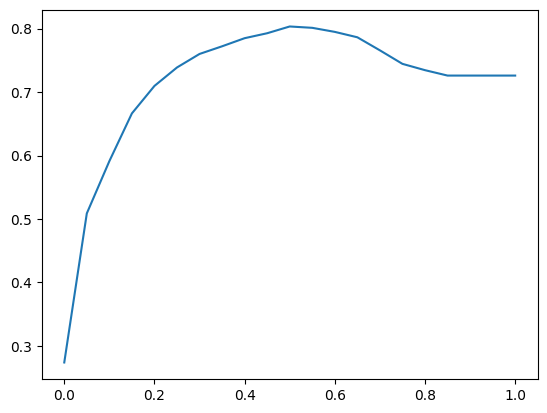

In [6]:
# We can measure the accuracy using different thresholds
# Here we are creating 21 thresholds between 0 and 1
thresholds = np.linspace(0, 1, 21)

scores = []

# And we can measure the accuracy for each threshold
for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('Threshold: %.2f Score: %.3f' % (t, score))
    scores.append(score)

# We plot the scores
plt.plot(thresholds, scores)

In [7]:
# We measured the accuracy with this:
#   churn_decision = (y_pred >= t)
#   score = (y_val == churn_decision).mean()
# But we can use the accuracy_score function from sklearn.metrics
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [8]:
# And the accuracy of the thresholds will be like this:
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('Threshold: %.2f Score: %.3f' % (t, score))
    scores.append(score)

Threshold: 0.00 Score: 0.274
Threshold: 0.05 Score: 0.509
Threshold: 0.10 Score: 0.591
Threshold: 0.15 Score: 0.666
Threshold: 0.20 Score: 0.710
Threshold: 0.25 Score: 0.739
Threshold: 0.30 Score: 0.760
Threshold: 0.35 Score: 0.772
Threshold: 0.40 Score: 0.785
Threshold: 0.45 Score: 0.793
Threshold: 0.50 Score: 0.803
Threshold: 0.55 Score: 0.801
Threshold: 0.60 Score: 0.795
Threshold: 0.65 Score: 0.786
Threshold: 0.70 Score: 0.766
Threshold: 0.75 Score: 0.744
Threshold: 0.80 Score: 0.735
Threshold: 0.85 Score: 0.726
Threshold: 0.90 Score: 0.726
Threshold: 0.95 Score: 0.726
Threshold: 1.00 Score: 0.726


In [9]:
# The threshold of 1.0 is interesting because it is a model that predicts that nobody will churn
# And even if we have a model that predicts that no customers will churn it will have 72% accuracy
# The difference between a model that predicts nobody will churn an our model the difference is 7% (sort of)
# This is because we have class imbalance (to many people will not churn and little people will churn)
# We will look to the numbers that can help us evaluate our model better.
from collections import Counter
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

# Confusion table

- Different types of errors and correct decissions
    - True Negatives: Correct (Predicted no churn and didn't churn)
    - False Negatives: Error (Predicted no churn and churned)
    - False Positive: Error (Predicted churn and didn't churn)
    - True Positivie: Correct (Predicted churn and churned)
- Arranging them in a table

In [10]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [11]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [17]:
# True positives: 210 (Correct)
tp = (predict_positive & actual_positive).sum()
# True negatives: 910 (Correct)
tn = (predict_negative & actual_negative).sum()
# False positives: (Error)
fp = (predict_positive & actual_negative).sum()
# False negatives: (Error)
fn = (predict_negative & actual_positive).sum()

In [19]:
# A confussion matrix is a way to have the sum results (Correct and Errors) in the same matrix
# Is a table like this:
#               Predictions
#                     Negative       |   Positive    |
#           Negative  922 (65%)      | 101 (7%) (Err)
#   Actual            -------------- | ------------- |
#           Positive  176 (12%) (Err)| 210 (14%)
# 
# We can notice we have a lot more False Negatives than False Positives
#
# Here instead of having 1 value we have 4 values
# And from the values of the confussion matrix we can derive more metrics
confussion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confussion_matrix

array([[922, 101],
       [176, 210]])

In [20]:
confussion_matrix / confussion_matrix.sum()

array([[0.6543648 , 0.07168204],
       [0.12491128, 0.14904187]])

# Precission and Recall

Metrics to validate binary classification models based on the values of the confussion table.

In [24]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy

np.float64(0.8034066713981547)

**Precission**: Fraction of positive predictions that are correct

In [25]:
# Precission is 67% so we sent promotional email to 33% of users that weren't going to churn (They probably will take advantage of our promitional emails)
precission = tp / (tp + fp)
precission

np.float64(0.6752411575562701)

**Recall**: Fraction of correctly identified positive examples

In [27]:
# Recall is 54% so we failed to identify 46% of users that were going to churn
# true positives / (true positives + false negatives)
recall = tp / (tp + fn)
recall

np.float64(0.5440414507772021)

We notice our model is not as accurate as we thought (80%) this is because we have a class imbalance in the data provided.

# ROC Curves

Receiver Operating Caracteristics (A way of describing the performance of a binary classification model).

Originaly, this idea was used on WWII to evaluate the strength of radar detectors.

For this we are interested in two numbers:
- FPR (False positive rate)
- TPR (True positive rate)

This metrics are computed from the values of the confussion matrix.

### TPR and FPR

- FPR: 
    - fp / (tn + fp)
    - false positives / (true negatives + false positives) 
    - We want to minimize false positive rate.
- TPR: 
    - tp / (fn * tp) 
    - true positives / (false negatives + true positives) 
    - We want to maximize true positive rate

In [28]:
# We want this to be as big as possible.
tpr = tp / (tp + fn) # Is the same as recall
tpr

np.float64(0.5440414507772021)

In [29]:
# we want this to be as small as possible, right now its almost 10%
fpr = fp / (tn + fp)
fpr

np.float64(0.09872922776148582)

In [30]:
# Instead of evaluating this two values for one threshold (0.5) but we want to evaluate it for multiple thresholds
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [31]:
scores

[(np.float64(0.0), np.int64(386), np.int64(1023), np.int64(0), np.int64(0)),
 (np.float64(0.01), np.int64(385), np.int64(913), np.int64(1), np.int64(110)),
 (np.float64(0.02), np.int64(384), np.int64(830), np.int64(2), np.int64(193)),
 (np.float64(0.03), np.int64(383), np.int64(766), np.int64(3), np.int64(257)),
 (np.float64(0.04), np.int64(381), np.int64(715), np.int64(5), np.int64(308)),
 (np.float64(0.05), np.int64(379), np.int64(685), np.int64(7), np.int64(338)),
 (np.float64(0.06), np.int64(377), np.int64(661), np.int64(9), np.int64(362)),
 (np.float64(0.07), np.int64(372), np.int64(641), np.int64(14), np.int64(382)),
 (np.float64(0.08), np.int64(371), np.int64(613), np.int64(15), np.int64(410)),
 (np.float64(0.09), np.int64(369), np.int64(580), np.int64(17), np.int64(443)),
 (np.float64(0.1), np.int64(366), np.int64(556), np.int64(20), np.int64(467)),
 (np.float64(0.11), np.int64(365), np.int64(528), np.int64(21), np.int64(495)),
 (np.float64(0.12), np.int64(365), np.int64(509), 

In [34]:
# We want to turn the scores into a DAtaFrame
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,150,53,236,970
70,0.7,76,20,310,1003
80,0.8,13,1,373,1022
90,0.9,0,0,386,1023


In [36]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.tn + df_scores.fp)
df_scores[::10]


,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


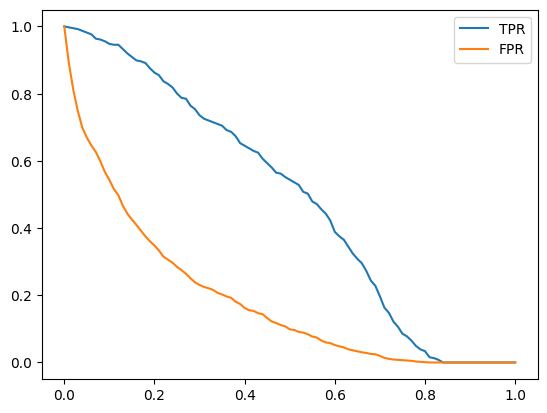

In [40]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR') # This should be as big as possible
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR') # This shold be as small as possible
plt.legend()

### Random model

Looking at the graph above doesn't give us enough insights because we don't have someting to compare against. 

So we want to do now is to have a baseline and for us it will be a random model.

In [42]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [43]:
((y_rand >= 0.5) == y_val).mean() # Accuracy for a random model is quite low (50%)

np.float64(0.5017743080198722)

In [44]:
def tpr_fpr_dataframe(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)

    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.tn + df_scores.fp)

    return df_scores

In [46]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


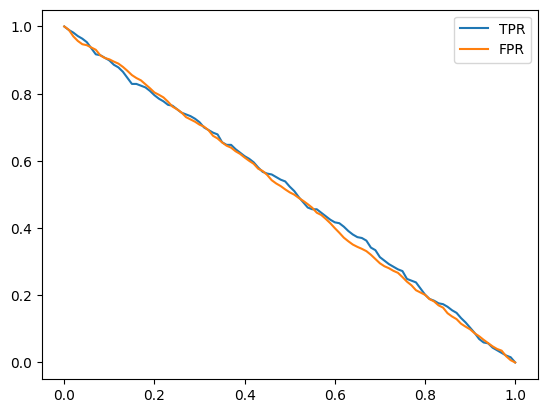

In [47]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR') # This should be as big as possible
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR') # This shold be as small as possible
plt.legend()

### Ideal Model

A model that outputs the correct prediction for everyone.

We want to take all the predictions and order them from smalles to largest.

The ideal model orders the customers in such a way that first we have all customers that are not churning (before the threshold) and then all the customers that are churning (after the threshold).

In [48]:
num_neg = (y_val == 0).sum() # Number of customers that are not churning
num_pos = (y_val == 1).sum() # Number of customers that are churning
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [50]:
y_ideal = np.repeat([0,1], [num_neg, num_pos]) # we have an array with 1023 zeros and 386 ones
y_ideal # This is kind of our validation set in a way, we know everything is ordered here

array([0, 0, 0, ..., 1, 1, 1])

In [51]:
# We need to create our predictions and this are just numbers between 0 and 1
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [53]:
1 - y_val.mean() # This is our ideal threshold

np.float64(0.7260468417317246)

In [54]:
((y_ideal_pred >= 0.726) == y_ideal).mean() # This is the accuracy of the ideal model

# This model doesn't exist in reality (it's impossible) but it allow us to benchmark our model against this one

np.float64(1.0)

In [55]:
# Let's do the same exercise we did for the random model
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


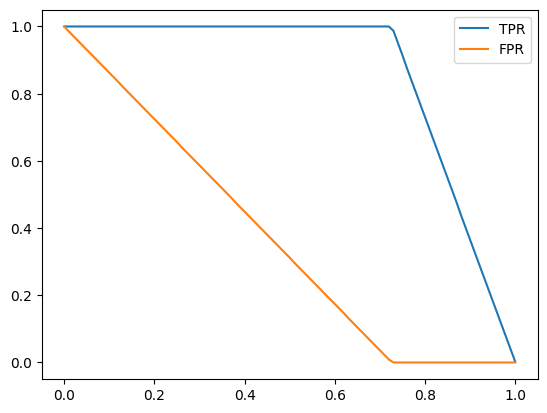

In [56]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR') # This should be as big as possible
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR') # This shold be as small as possible
plt.legend()

### Putting it all together

Try to plot all the benchmarks together

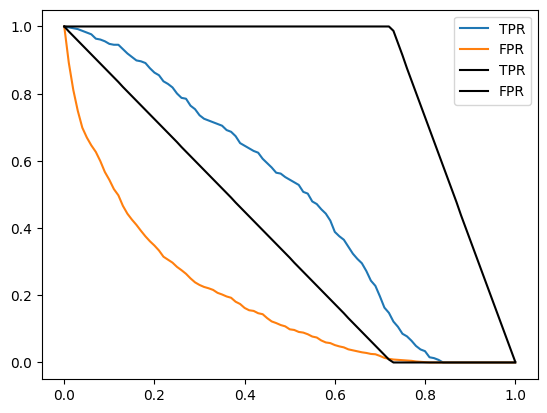

In [59]:
# Our model
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR') 
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')

# Random model
# plt.plot(df_rand.threshold, df_rand.tpr, label='TPR') 
# plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')

# Ideal model
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR', color='black')

plt.legend()

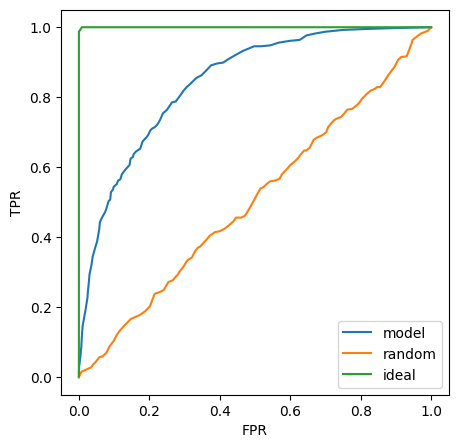

In [65]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

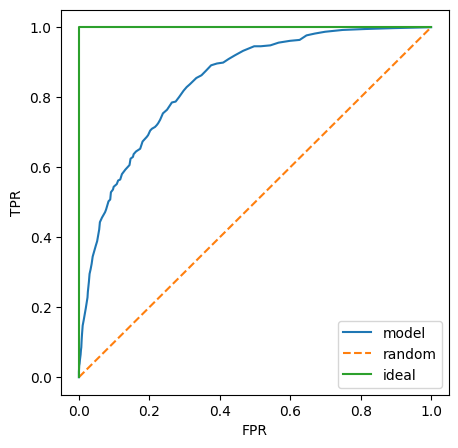

In [71]:

plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
# plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')
# plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')
plt.plot([0, 0, 1], [0, 1, 1], label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [72]:
# And we can use scklearn for this...
from sklearn.metrics import roc_curve

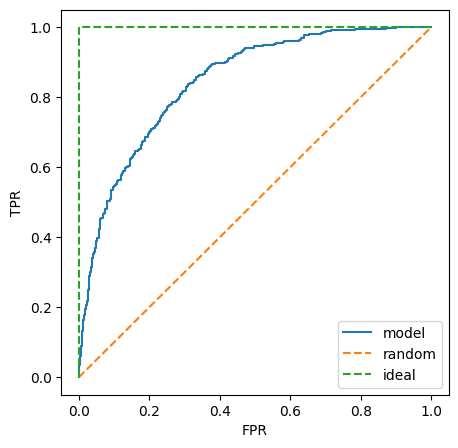

In [76]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')
plt.plot([0, 0, 1], [0, 1, 1], label='ideal', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()